In [1]:

import numpy as np
import pathlib as pl
import os
import pandas as pd
import warnings
warnings.simplefilter("ignore")
from copy import copy
from candas.learn import GP_gpflow, LVMOGP_GP
from candas.learn import ParameterSet
import tensorflow as tf
from plotting_scripts import contourf_uparray, fit_lmc_from_hps, fit_avg_from_hps, fit_lvmogp_from_hps, \
        plot_all_surfaces, get_test_points, get_prediction, plot_surface, make_axes_locatable
# from candas.plotting.regression_plots import plot_uparray, contourf_uparray, parray, Standardizer
from candas.style import futura
from gpflow.utilities import read_values
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import candas
mpl.style.use('mystyle.mplstyle')

inch_conversion = 3.93701/100
page_width = 142.4 *inch_conversion
column_width = 67.2* inch_conversion

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Create Plots of the Surfaces in Bayesian Optimisation Run

In this notebook, we make plots of the surfaces for a given test scenario, for a given parameter at a certain iteration.
This is to help us visualise what is going on with each of the models at different iterations.

## Specify the Test Case We Want to Plot


In [2]:
learning_surface = 'FP005-FP004-EvaGreen' #'FP002-RP002x-EvaGreen' #'FP001-RP001x-Probe'  #'FP001-RP001x-EvaGreen' #'FP001-RP001x-Probe' #'FP001-RP001x-Probe' # 'FP001-RP001x-EvaGreen' #

surface_name = 'one_from_many' # 'many' #'many' #'many_both_0_point_start'
start_point_name = '0_point_start' #'0_point_start' #'centre'

if surface_name == 'one_from_many':
    learning_surface_ = f'{learning_surface}'
    test_name = f'{surface_name}_{learning_surface_}_both_{start_point_name}'
else:
    learning_surface_ = ''
    test_name = f'{surface_name}_both_{learning_surface_}{start_point_name}'
param_name = 'r'
#'worst_point_' #worst_point' #'worst_point' # ''
# test_name = f'{surface_name}{learning_surface}_both{start_point_name}'
# test_name = f'{surface_name}_both_{learning_surface_}{start_point_name}'
log_t = 'No_Transform'
param = 'r'
iteration = 1
seed = 2
MAP=False
log_transform = False
save=False
restarts = 10
restarts_extra = '10_2208_constrained'
params = ['r', 'm']
random_if_none=True

## Plot the Models

Load the hyperparameters

In [3]:
model_names = [ 'mo_indi', 'avg',  'lmc', 'lvm'] # 'mo_indi','lmc',

In [4]:
hyp_dict = {mod_name:{'r': None, 'm':None} for mod_name in model_names}
param_dict = {mod_name:{'r': None, 'm':None} for mod_name in model_names}

for mod_name in model_names:
    for param_name in params:
        path = pl.Path.home()/f'Hyperparameters/restarts_{restarts_extra}'
        with open(path / (f'hyperparameters_{mod_name}_{test_name}_{random_if_none}_{param_name}_iteration_{iteration}_seed_{seed}_{restarts}.pkl'), "rb") as file:
                hyper_params = pickle.load(file)
        hypparams = hyper_params['hyperparameters'][0]
        param_set = hyper_params['parameter array'][0]
        hyp_dict[mod_name][param_name] = hypparams
        param_dict[mod_name][param_name] = param_set

        if not log_transform:
            param_set.stdzr.transforms['r'] = [candas.utils.skip, candas.utils.skip]
            param_set.stdzr.transforms['m'] = [candas.utils.skip, candas.utils.skip]
            for param in ['r', 'm']:
                param_set.stdzr[param] = {'μ': param_set.data.loc[(param_set.data['Parameter'] == param) & (param_set.data['Metric'] == 'mean'), 'Value'].mean(),
                                   'σ': param_set.data.loc[(param_set.data['Parameter'] == param) & (param_set.data['Metric'] == 'mean'), 'Value'].std()}
        else:
            pass

Fit the average GP from the hyperparameters

In [5]:
gp_dict = {mod_name:{'r': None, 'm':None} for mod_name in model_names}
for mod_name in model_names:
    for param_name in params:
        if mod_name == 'avg':
            gp = fit_avg_from_hps(param_dict[mod_name][param_name], hyp_dict[mod_name][param_name], param_name)
        elif mod_name in ['mo_indi', 'lmc']:
            gp = fit_lmc_from_hps(param_dict[mod_name][param_name], hyp_dict[mod_name][param_name], param_name)
        else:
            gp = fit_lvmogp_from_hps(param_dict[mod_name][param_name], hyp_dict[mod_name][param_name], param_name)
        gp_dict[mod_name][param_name] = gp

<Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.09982905982905983>
<Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.09982905982905983>
<Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.09982905982905983>
<Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.09982905982905983>
<Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.09982905982905983>
<Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=0.09982905982905983>


2023-09-13 16:04:56.527441: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Get predictions

In [12]:
from gpflow.base import default_float

def weighted_mean(means, variances):
    """calculate the weighted mean
    :param means: the means of the values
    :param variances: the variances of the values
    :return: the weighted mean"""
    weighted_avg = np.sum(means / variances, axis=0) / np.sum(1 / variances, axis=0)
    return np.expand_dims(weighted_avg, axis=0)

def weighted_variance(means, variances):
    """calculate the weighted variances
    :param means: the means of the values
    :param variances: the variances of the values
    :return: the weighted variance"""
    weighted_var = np.var(means, axis=0) + np.mean(variances, axis=0)
    return np.expand_dims(weighted_var, axis=0)


def load_targets():
    """function to load the target values for each of the surfaces
    :returns targets: a dataframe of the target values"""

    path = pl.Path(os.getcwd()).parent
    with open(path / 'data' / 'JG067 sequence targets.csv', "rb") as file:
        targets = pd.read_csv(file)
    targets['PrimerPair'] = targets[['FPrimer', 'RPrimer']].agg('-'.join, axis=1)
    targets['EvaGreen'] = ((targets['-Strand Label'] == "None") & (targets['+Strand Label'] == "None"))
    targets.loc[targets['EvaGreen'] == True, 'EvaGreen'] = 'EvaGreen'
    targets.loc[targets['EvaGreen'] == False, 'EvaGreen'] = 'Probe'
    targets['PrimerPairReporter'] = targets[['PrimerPair', 'EvaGreen']].agg('-'.join, axis=1)
    targets = targets.drop_duplicates(subset=['PrimerPairReporter'], keep='first')

    return targets


def create_unseen_levels(models, params, targets, reporters=False, primers=False):
    """get latent variables for the surfaces with no observed data for the LVMOGP. This is done by taking a weighted
    average of the latent variables of the surfaces with the same reporter and primer pair (dependent on the bool
    of those two parameters)
    :param targets: the targets to be used
    :param reporters: whether to use reporters
    :param primers: whether to use primers"""

    if primers:
        reporters = True

    for param in params:
        lvm = models['lvm'][param]
        len_coreg = len(lvm.coregion_coords['PrimerPairReporter'])
        j = 0
        methods = {}
        same_reporter_dict = {}
        if reporters:
            for reporter in targets['EvaGreen'].unique():
                same_reporter_dict[reporter] = lvm.data.data.loc[
                    lvm.data.data['EvaGreen'] == reporter, 'PrimerPairReporter'].unique()

        if primers:
            same_P_dict = {}

            for FP in np.unique(targets['FPrimer'].tolist() + targets['RPrimer'].tolist()):
                same_P_dict[FP] = np.unique(
                    lvm.data.data.loc[lvm.data.data['FPrimer'] == FP, 'PrimerPairReporter'].tolist() + \
                    lvm.data.data.loc[lvm.data.data['RPrimer'] == FP, 'PrimerPairReporter'].tolist())

        for i, targ in enumerate(targets['PrimerPairReporter'].unique()):
            method = 'observed data'
            if targ not in list(lvm.coregion_coords['PrimerPairReporter'].keys()):
                lvm.coregion_coords['PrimerPairReporter'][targ] = len_coreg + j
                if reporters:
                    reporter = targets.loc[targets['PrimerPairReporter'] == targ, 'EvaGreen'].iloc[0]
                    if primers:
                        FPrimer = targets.loc[targets['PrimerPairReporter'] == targ, 'FPrimer'].iloc[0]
                        RPrimer = targets.loc[targets['PrimerPairReporter'] == targ, 'RPrimer'].iloc[0]
                        same_Primer = same_P_dict[FPrimer].tolist() + same_P_dict[RPrimer].tolist()
                        # same_Primer = same_RP_dict[RPrimer].tolist() + same_FP_dict[FPrimer].tolist()
                        same_primer_and_reporter = list(set(same_reporter_dict[reporter]).intersection(same_Primer))
                        if len(same_primer_and_reporter) < 2:
                            same_primer_and_reporter = same_reporter_dict[reporter]
                            method = 'reporter'
                        method = "reporter + primers"
                        if len(list(set(same_reporter_dict[reporter]).intersection(
                                same_P_dict[FPrimer].tolist()))) == 0 or \
                                len(list(set(same_reporter_dict[reporter]).intersection(
                                    same_P_dict[RPrimer].tolist()))) == 0:
                            same_primer_and_reporter = same_reporter_dict[reporter]
                            method = 'reporter'
                    else:
                        same_primer_and_reporter = same_reporter_dict[reporter]
                        method = 'reporter'

                    same_reporter_index = [lvm.coregion_coords['PrimerPairReporter'][rep]
                                           for rep in same_primer_and_reporter]

                    H_means = copy(lvm.model.H_data_mean).numpy()[same_reporter_index, :]
                    H_vars = copy(lvm.model.H_data_var).numpy()[same_reporter_index, :]
                    H_mean = tf.convert_to_tensor(weighted_mean(H_means, H_vars), dtype=default_float())
                    H_var = tf.convert_to_tensor(weighted_variance(H_means, H_vars), dtype=default_float())
                else:
                    H_mean = tf.zeros((1, lvm.model.H_data_mean.shape[1]), dtype=default_float())
                    H_var = tf.ones((1, lvm.model.H_data_mean.shape[1]), dtype=default_float())
                    method = 'prior'

                lvm.model.H_data_mean = tf.concat([lvm.model.H_data_mean, H_mean], axis=0)
                lvm.model.H_data_var = tf.concat([lvm.model.H_data_var, H_var], axis=0)
                j = j + 1
            methods[targ] = method
        models['lvm'][param] = lvm
    return models

In [13]:
if (iteration == 0) & (start_point_name == '0_point_start'):
    targets = load_targets()
    create_unseen_levels(gp_dict, params, targets, reporters=True, primers=True)

In [14]:
xy_pas_dict = {mod_name:{'r': None, 'm':None} for mod_name in model_names}
z_upas_dict = {mod_name:{'r': None, 'm':None} for mod_name in model_names}
pp_dict = {mod_name:{'r': None, 'm':None} for mod_name in model_names}
test_locations_dict = {mod_name:{'r': None, 'm':None} for mod_name in model_names}
for mod_name in model_names:
    for param_name in params:
        test_locations = get_test_points(pl.Path(os.getcwd()).parent, param_dict[mod_name][param_name])
        if learning_surface in test_locations['PrimerPairReporter'].unique():
            test_points = test_locations[test_locations['PrimerPairReporter'] == learning_surface][['BP', 'GC']]
            test_points = gp_dict[mod_name][param_name].parray(**{name: test_points[name] for name in test_points.columns})
        else:
            test_points = None
        test_locations_dict[mod_name][param_name] = test_points

        if mod_name == 'avg':
            pprs = 0
        else:

            pprs = gp_dict[mod_name][param_name].coregion_coords['PrimerPairReporter']

        xy_pas, z_upas, pp = get_prediction(gp_dict[mod_name][param_name],
                                            mod_name, learning_surface, pprs, {}, {})
        xy_pas_dict[mod_name][param_name] = xy_pas
        z_upas_dict[mod_name][param_name] = z_upas
        pp_dict[mod_name][param_name] = pp

Get the expected improvements

In [15]:

def create_target_parrays(ppr, model, params, targets):
    """create parrays for each parameter for the target point
    :param i: the index of the target point
    :param model: the model """
    target_parrays = {}
    for param in params:
        if param == 'r':
            target_parrays[param] = model['r'].parray(**{'r': targets[targets['PrimerPairReporter']==ppr]['Target Rate']})
        elif param == 'm':
            target_parrays[param] = model['m'].parray(**{'m': 1e-2}, stdzd=False)

        else:
            raise AssertionError(f'param {param} isn\'t r or m')
    return target_parrays

In [16]:
targets = load_targets()

In [17]:
from experiments.expected_improvements import ExpectedImprovementConstrained

EI = ExpectedImprovementConstrained(params)
eis_dict = {mod_name: {} for mod_name in model_names}
for mod_name in ['mo_indi', 'avg', 'lmc', 'lvm']:
    model = gp_dict[mod_name]
    target_parrays = create_target_parrays(learning_surface, model, params, targets)
    ys = {}
    ys_parray = {}
    preds = {}
    for param in params:
        ys_ = param_dict[mod_name][param].data[
            (param_dict[mod_name][param].data['Parameter']
             == param) & (param_dict[mod_name][param].data[
                              'PrimerPairReporter'] == learning_surface)
            & (param_dict[mod_name][param].data[
                   'Metric'] == 'mean')]
        ys[param] = ys_.groupby(['BP', 'GC', 'PrimerPairReporter']).mean().reset_index()['Value']
        ys_parray[param] = model[param].parray(**{param: ys[param]})
        preds[f'{param}_mu_z'] = z_upas_dict[mod_name][param][learning_surface].z.μ.ravel()
        preds[f'{param}_sig2_z'] = z_upas_dict[mod_name][param][learning_surface].z.σ2.ravel()

    if (iteration == 0) & (start_point_name == '0_point_start'):
        best_yet = np.ones(1, ) * 4
    else:
        best_yet = EI.BestYet({param: ys_parray[param].z.values() for param in  params},
                                                   target_parrays)
    mu =  np.atleast_2d(preds[f'r_mu_z']).T
    sig2 = np.atleast_2d(preds[f'r_sig2_z']).T
    target = np.atleast_2d(target_parrays['r'].z.values())

    mu_m = np.atleast_2d(preds[f'm_mu_z']).T
    sig2_m =  np.atleast_2d(preds[f'm_sig2_z']).T
    threshold_m =  np.atleast_2d(target_parrays['m'].z.values())

    k = 1
    chi_ei = EI.Chi_EI(mu, sig2, target, best_yet, k=k)
    ef = EI.expected_feasibility(mu_m.flatten(), sig2_m.flatten(), threshold_m.flatten())
    ei = chi_ei.flatten() * ef.flatten()
    eis_dict[mod_name][learning_surface] = ei.reshape(100, 100)

In [19]:
with open(pl.Path(os.getcwd()).parent/ 'data'/f'best_df_constrained.pkl', "rb") as file:
    best_df = pickle.load(file)

Plot the predictions of the model

In [20]:
from candas.learn import ParameterArray, UncertainParameterArray, ParameterSet, Standardizer
from candas.learn import parray, uparray

def unstandardize_axis_labels(ax, axis, array):
    if axis == 'x':
        ticks = ax.get_xticks()
        set_labels = ax.set_xticklabels
    elif axis == 'y':
        ticks = ax.get_yticks()
        set_labels = ax.set_yticklabels
    elif axis == 'z':
        ticks = ax.get_zticks()
        set_labels = ax.set_zticklabels

    if isinstance(array, ParameterArray):
        name = array.names[0]
        stdzr = array.stdzr
    elif isinstance(array, UncertainParameterArray):
        name = array.name
        stdzr = array.dstdzr.stdzr
    else:
        raise TypeError('Argument "array" must be either a ParameterArray or an UncertainParameterArray.')

    ticks = parray(**{name: ticks}, stdzr=stdzr, stdzd=True)
    set_labels(ticks.values())


(100, 100)
(100, 100)
(100, 100)
(100, 100)


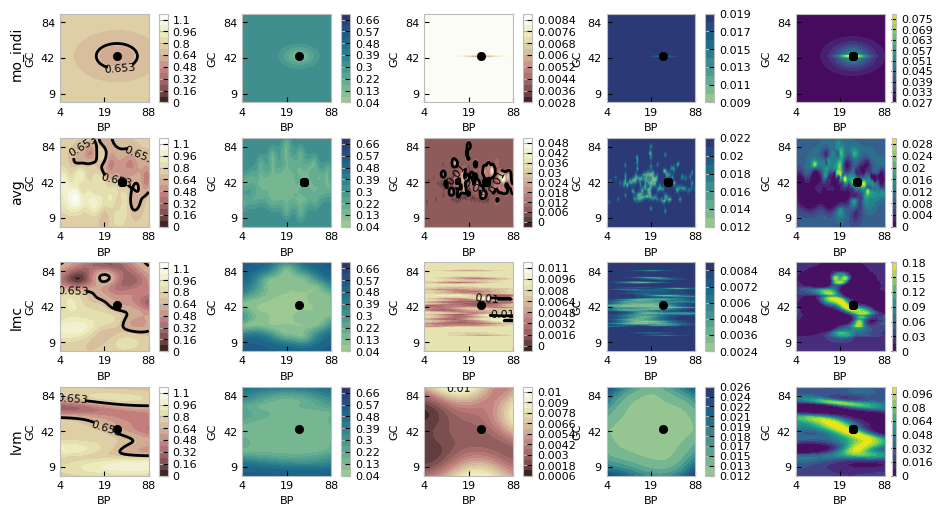

In [21]:
import seaborn as sns
fig, axs_ = plt.subplots(nrows=4, ncols=len(params)*2 +1, figsize=(page_width*2, 6))

xy_pas = {}
z_upas = {}

limits = {'r': {'mu':[0, 1.2], 'sig': [0.04, 0.7]},
          'm':{'mu':None,  'sig': None}}
full_width = 5.5984252
page_height = 7.85
halfwidth = 2.645669

for j, mod_name in enumerate(model_names):

    for i, param_name in enumerate(params):
        locations = param_dict[mod_name][param_name].data[['BP', 'GC', 'PrimerPairReporter']]
        plot_surface(xy_pas_dict[mod_name][param_name], z_upas_dict[mod_name][param_name],
                     gp_dict[mod_name][param_name], mod_name, learning_surface, pp_dict[mod_name][param_name],
                     param_name,None, stdz=False, save=False, limits=limits[param_name],
                      axs=axs_[j, i*2:(i+1)*2], input_locations=locations)
        # axs_[0].set_title(r'$\mu$')
        # axs_[1].set_title(r'$2\sigma$')
        # axs_[0].grid(False)
        # axs_[1].grid(False)
    # test = threshold_m.flatten()[0]
    # test2  =xy_pas_dict[mod_name][param_name][learning_surface]['BP']
    # test3 = z_upas_dict[mod_name][param_name][learning_surface]

    CS = axs_[j, 0].contour(*[xy_pas_dict[mod_name]['r'][learning_surface]['BP'].z,
                       xy_pas_dict[mod_name]['r'][learning_surface]['GC'].z],
                          z_upas_dict[mod_name]['r'][learning_surface].μ,
                                 levels=[targets[targets['PrimerPairReporter']
                                                == learning_surface]['Target Rate'].to_numpy()[0]], colors='k')
    axs_[j, 0].clabel(CS, inline=True, fontsize=8)

    axs_[j, 0].annotate(mod_name, xy=(-50, 25), rotation=90, xycoords='axes pixels')


    CS = axs_[j, 2].contour(*[xy_pas_dict[mod_name]['m'][learning_surface]['BP'].z,
                       xy_pas_dict[mod_name]['m'][learning_surface]['GC'].z],
                          z_upas_dict[mod_name]['m'][learning_surface].μ,
                                 levels=[0.01], colors='k')

    axs_[j, 2].clabel(CS, inline=True, fontsize=8)


    # ax.clabel(CS, inline=True, fontsize=10)

    print(eis_dict[mod_name][learning_surface].shape)
    defaults = dict(levels=16, cmap='viridis')
    contour = axs_[j, -1].contourf(*[xy_pas_dict[mod_name][param_name][learning_surface]['BP'].z,
                       xy_pas_dict[mod_name][param_name][learning_surface]['GC'].z],
                          eis_dict[mod_name][learning_surface], **{**defaults})
    input_locations = param_dict[mod_name][param_name].data[['BP', 'GC', 'PrimerPairReporter']]
    input_locations = input_locations[input_locations['PrimerPairReporter'] == learning_surface]
    Xs = gp_dict[mod_name]['r'].parray(**{'BP': input_locations['BP'], 'GC': input_locations['GC']})
    Xs = np.squeeze(np.hstack([np.atleast_2d(Xs['BP'].z.values()).T,
                                   np.atleast_2d(Xs['GC'].z.values()).T]))
    Xs = Xs.reshape(len(Xs), 2)
    axs_[j, -1].scatter(Xs[:, 0], Xs[:, 1], marker='o', color='k', zorder=10)

    #
    # axs_[j, 4].scatter(xy_pas_dict[mod_name][param_name][learning_surface]['BP'].z.values(),
    #                                                 xy_pas_dict[mod_name][param_name][learning_surface]['GC'].z.values(),
    #                    marker='o', facecolors='none', linewidth=1.5, alpha=0.5, color='white', zorder=6)
    # cbar = plt.colorbar(cont, ax=axs[i], cax=cax1, format='%.2g')
    cbar = plt.colorbar(contour, ax=axs_[j, -1] ,format='%.2g')

    best_point = best_df[best_df['PrimerPairReporter'] == learning_surface]

    best_point_parray = gp_dict[mod_name][param].parray(**{'GC': best_point['GC'], 'BP': best_point['BP']})

    for ax in axs_.flatten():
        ax.set_aspect('equal')
        ax.set_title('')
        ax.grid(False)
        # ax.scatter(best_point_parray['BP'].z.values(),best_point_parray['GC'].z.values(),
        #                marker='o', facecolors='none', linewidth=1.5, alpha=0.5, color='r', zorder=6)
        # ax.scatter(test_locations_dict[mod_name][param_name]['BP'].z.values(),
        #                                             test_locations_dict[mod_name][param_name]['GC'].z.values(),
        #                marker='o', facecolors='none', linewidth=1.5, alpha=0.5, color='white', zorder=5)


    for ax in axs_[:, -1].flatten():
        ax.set_xticklabels([int(float(txt.get_text())) for txt in axs_[0, 0].get_xticklabels()])
        ax.set_yticklabels([int(float(txt.get_text())) for txt in axs_[0, 0].get_yticklabels()])
        ax.set_xlabel('BP')
        ax.set_ylabel('GC')

fig.subplots_adjust(wspace=0.3, hspace=0.4)

plt.savefig(f'plots/preds_and_ei_iteration_{learning_surface}_{iteration}_seed_{seed}_restarts_{restarts}.svg', bbox_inches='tight')
plt.savefig(f'plots/preds_and_ei_iteration_{learning_surface}_{iteration}_seed_{seed}_restarts_{restarts}.png', bbox_inches='tight', dpi=2000)


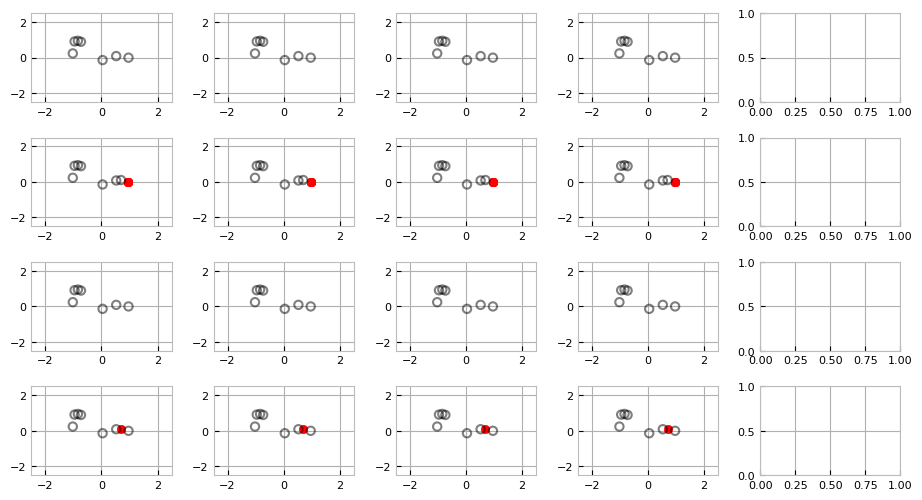

In [22]:

fig, axs_ = plt.subplots(nrows=4, ncols=5, figsize=(page_width*2, 6))

xy_pas = {}
z_upas = {}

limits = {'r': {'mu':[0.15, 1.2], 'sig': [0.04, 0.55]},
          'm':{'mu':None,  'sig': None}}
full_width = 5.5984252
page_height = 7.85
halfwidth = 2.645669

for j, mod_name in enumerate(model_names):
    for i, param_name in enumerate(['r', 'm']):
        locations = param_dict[mod_name][param_name].data[['BP', 'GC', 'PrimerPairReporter']]

        pp_name = learning_surface
        axs = axs_[j, i*2:(i+1)*2]
        model_name = mod_name
        input_locations = locations

        model = gp_dict[model_name][param_name]
        test_points = test_locations_dict[model_name][param_name]

        xy_pa = xy_pas_dict[mod_name][param_name][pp_name]
        z_upa = z_upas_dict[mod_name][param_name][pp_name]

        if model_name in ['lmc', 'mo_indi']:
            indices = np.argwhere(model.X['PrimerPairReporter'].z.values() == pp)[:, 0]
            Xs = np.squeeze(np.hstack([model.X['BP'].values()[indices],
                                       model.X['GC'].values()[indices]]))
            Xs = Xs.reshape(len(indices), 2)
        elif model_name == 'avg':
            locs = input_locations[input_locations['PrimerPairReporter'] == pp_name]
            Xs = model.parray(**{'BP': locs['BP'], 'GC': locs['GC']})
            Xs = np.squeeze(np.hstack([np.atleast_2d(Xs['BP'].z.values()).T,
                                       np.atleast_2d(Xs['GC'].z.values()).T]))
            # Xs = np.squeeze(model.model.data[0].numpy())
            Xs = Xs.reshape(len(Xs), 2)
        else:
            indices = np.argwhere(model.model.X_data_fn.numpy() == pp)
            Xs = np.squeeze(model.model.X_data.numpy()[indices])
            Xs = Xs.reshape(len(indices), 2)

        axs[0].scatter(Xs[:, 0], Xs[:, 1], marker='o', color='r', zorder=5)
        axs[1].scatter(Xs[:, 0], Xs[:, 1], marker='o', color='r', zorder=5)
        axs[0].set_xlim(xy_pa['BP'].z.values().min(),xy_pa['BP'].z.values().max() )
        axs[0].set_ylim(xy_pa['GC'].z.values().min(),xy_pa['GC'].z.values().max() )
        axs[1].set_xlim(xy_pa['BP'].z.values().min(),xy_pa['BP'].z.values().max() )
        axs[1].set_ylim(xy_pa['GC'].z.values().min(),xy_pa['GC'].z.values().max() )
        axs[0].scatter(test_points['BP'].z.values(), test_points['GC'].z.values(),
                       marker='o', facecolors='none', linewidth=1.5, alpha=0.5, color='k', zorder=5)
        axs[1].scatter(test_points['BP'].z.values(), test_points['GC'].z.values(),
                           marker='o', facecolors='none', linewidth=1.5, alpha=0.5, color='k', zorder=5)


fig.subplots_adjust(wspace=0.3, hspace=0.4)

In [23]:
# plt.savefig(f'plots/preds_and_ei_iteration_{iteration}_seed_{seed}_restarts_{restarts}.svg', bbox_inches='tight')
# plt.savefig(f'plots/preds_and_ei_iteration_{iteration}_seed_{seed}_restarts_{restarts}.png', bbox_inches='tight', dpi=2000)

In [24]:
test = z_upas_dict['avg']['r'][learning_surface].z.μ.flatten()
print(max(test))

2.62920527164094


Plot the Latent Coordinates of the LVMOGP

['FP004-RP004-Probe', 'FP001-RP001-Probe', 'FP002-RP002-Probe', 'FP001-RP005-Probe', 'FP005-RP005-Probe', 'FP002-RP006-Probe', 'FP006-RP006-Probe', 'FP003-RP008-Probe', 'FP002-RP002x-Probe', 'FP004-RP004x-Probe', 'FP001-RP001x-Probe', 'FP003-RP003-Probe', 'FP057.1.0-RP003x-Probe', 'FP005-FP001-Probe', 'RP001x-FP002-Probe', 'RP002x-FP005-Probe', 'FP004-FP005-Probe', 'RP008x-FP005-Probe', 'FP004-RP004-EvaGreen', 'FP001-RP001-EvaGreen', 'FP002-RP002-EvaGreen', 'FP001-RP001x-EvaGreen', 'FP002-RP002x-EvaGreen', 'FP004-RP004x-EvaGreen', 'FP003-RP008-EvaGreen', 'FP003-RP008x-EvaGreen', 'FP057.1.0-RP003x-EvaGreen', 'RP002x-FP002-EvaGreen', 'FP001-RP004-EvaGreen', 'FP002-RP004-EvaGreen', 'FP005-FP001-EvaGreen', 'RP002x-FP004-EvaGreen', 'RP008x-FP001-EvaGreen', 'FP005-FP004-EvaGreen']


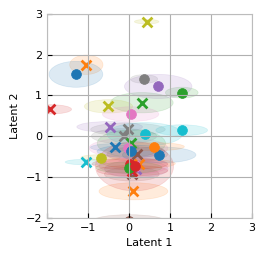

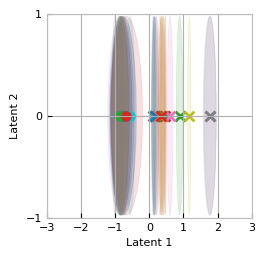

In [25]:
from matplotlib.patches import Ellipse

pprs = gp_dict['lvm']['r'].coregion_coords['PrimerPairReporter'].keys()
pprs_probes = list(filter(lambda ppr: 'Probe' in ppr, pprs))
pprs_evagreen = list(filter(lambda ppr: 'EvaGreen' in ppr, pprs))
pprs = pprs_probes + pprs_evagreen
print(pprs)
for param, hyper_params in hyp_dict['lvm'].items():
    H_mean = hyper_params['.H_data_mean']
    H_var = hyper_params['.H_data_var']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']*10
    fig = plt.figure(figsize=(column_width, column_width)); ax = plt.gca()
    # for i in range(len(H_mean)):
    for ppr in pprs:
        i = gp_dict['lvm']['r'].coregion_coords['PrimerPairReporter'][ppr]
        # for key, value in gp_dict['lvm']['r'].coregion_coords['PrimerPairReporter'].items():
        #     if value == i:
        #         ppr = key
        if 'EvaGreen' in ppr:
            marker='o'

        else:
            marker = 'x'

        ax.scatter(H_mean[i, 0], H_mean[i, 1], label=f'{ppr}',
                   color=colors[i], marker=marker, s=50)
        # ax.annotate(f'{list(model.coregion_coords["PrimerPairReporter"].keys())[i]}', (h[dims[0]], h[dims[1]]), fontsize=10)
        ax.set_xlabel(f'Latent 1')
        ax.set_ylabel(f'Latent 2')
        # ax.set_title('LVM Latent Variable Coordinates')
        circle1 = Ellipse((H_mean[i, 0], H_mean[i, 1]), 1.95 * np.sqrt(H_var[i, 0]),
                          1.95 * np.sqrt(H_var[i, 1]), color=colors[i], alpha=0.15, zorder=0)
        ax.add_patch(circle1)
        # ax.legend(loc='center left', ncol=2, bbox_to_anchor=(1, 0.5))
    if param == 'r':
        ax.set_xlim(-2, 3)
        ax.set_ylim(-2, 3)
    if param == 'm':
        ax.set_xlim(-3, 3)
        ax.set_ylim(-1, 1)
        ax.set_yticks([-1, 0, 1])

    path = pl.Path.home()/'surface_plots'
    plt.savefig(path /f'LVM_latents_{surface_name}_{iteration}_{test_name}_{seed}_{param}.pdf', bbox_inches='tight')
    plt.savefig(path /f'LVM_latents_{surface_name}_{iteration}_{test_name}_{seed}_{param}.svg', bbox_inches='tight')

['FP004-RP004-Probe', 'FP001-RP001-Probe', 'FP002-RP002-Probe', 'FP001-RP005-Probe', 'FP005-RP005-Probe', 'FP002-RP006-Probe', 'FP006-RP006-Probe', 'FP003-RP008-Probe', 'FP002-RP002x-Probe', 'FP004-RP004x-Probe', 'FP001-RP001x-Probe', 'FP003-RP003-Probe', 'FP057.1.0-RP003x-Probe', 'FP005-FP001-Probe', 'RP001x-FP002-Probe', 'RP002x-FP005-Probe', 'FP004-FP005-Probe', 'RP008x-FP005-Probe', 'FP004-RP004-EvaGreen', 'FP001-RP001-EvaGreen', 'FP002-RP002-EvaGreen', 'FP001-RP001x-EvaGreen', 'FP002-RP002x-EvaGreen', 'FP004-RP004x-EvaGreen', 'FP003-RP008-EvaGreen', 'FP003-RP008x-EvaGreen', 'FP057.1.0-RP003x-EvaGreen', 'RP002x-FP002-EvaGreen', 'FP001-RP004-EvaGreen', 'FP002-RP004-EvaGreen', 'FP005-FP001-EvaGreen', 'RP002x-FP004-EvaGreen', 'RP008x-FP001-EvaGreen', 'FP005-FP004-EvaGreen']


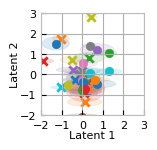

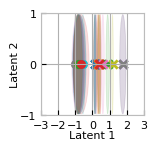

In [26]:

from matplotlib.patches import Ellipse

pprs = gp_dict['lvm']['r'].coregion_coords['PrimerPairReporter'].keys()
pprs_probes = list(filter(lambda ppr: 'Probe' in ppr, pprs))
pprs_evagreen = list(filter(lambda ppr: 'EvaGreen' in ppr, pprs))
pprs = pprs_probes + pprs_evagreen
print(pprs)
for param, hyper_params in hyp_dict['lvm'].items():
    H_mean = hyper_params['.H_data_mean']
    H_var = hyper_params['.H_data_var']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']*10
    fig = plt.figure(figsize=(0.5*column_width, 0.5*column_width)); ax = plt.gca()
    # for i in range(len(H_mean)):
    for ppr in pprs:
        i = gp_dict['lvm']['r'].coregion_coords['PrimerPairReporter'][ppr]
        # for key, value in gp_dict['lvm']['r'].coregion_coords['PrimerPairReporter'].items():
        #     if value == i:
        #         ppr = key
        if 'EvaGreen' in ppr:
            marker='o'

        else:
            marker = 'x'

        ax.scatter(H_mean[i, 0], H_mean[i, 1], label=f'{ppr}',
                   color=colors[i], marker=marker)
        # ax.annotate(f'{list(model.coregion_coords["PrimerPairReporter"].keys())[i]}', (h[dims[0]], h[dims[1]]), fontsize=10)
        ax.set_xlabel(f'Latent 1', labelpad=0)
        ax.set_ylabel(f'Latent 2', labelpad=0)
        # ax.set_title('LVM Latent Variable Coordinates')
        circle1 = Ellipse((H_mean[i, 0], H_mean[i, 1]), 1.95 * np.sqrt(H_var[i, 0]),
                          1.95 * np.sqrt(H_var[i, 1]), color=colors[i], alpha=0.15, zorder=0)
        ax.add_patch(circle1)
        # ax.legend(loc='center left', ncol=2, bbox_to_anchor=(1, 0.5))
    if param == 'r':
        ax.set_xlim(-2, 3)
        ax.set_ylim(-2, 3)
        ax.set_xticks([-2, -1, 0, 1, 2, 3])
        ax.set_yticks([-2, -1, 0, 1, 2, 3])
    if param == 'm':
        ax.set_xlim(-3, 3)
        ax.set_ylim(-1, 1)
        ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])
        ax.set_yticks([-1, 0, 1])
    # plt.subplots_adjust(hspace=0.01, wspace=0.01, left=None, bottom=0.18, right=None, top=1)
    # plt.margins(y=0)
    # plt.tight_layout()
    path = pl.Path.home()/'surface_plots'
    plt.savefig(path /f'LVM_latents_{surface_name}_{iteration}_{test_name}_{seed}_{param}_smaller.pdf', bbox_inches='tight')
    plt.savefig(path /f'LVM_latents_{surface_name}_{iteration}_{test_name}_{seed}_{param}_smaller.svg', bbox_inches='tight')